<a href="https://colab.research.google.com/github/yuehanui/pre_trained_CNN_transfer_learning/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Trained Convolutional Neural Network and Transfer Learning
*   Johnny Wang - yw4504
*   Yao Ma - ym2139





## Introduction
A Convolutional Neural Network can achieve exceptional result on image recognition tasks. But it requires tremendous amount of computational power to train. As a result, it is either time-consuming, if trained using a local machine, or money-comsuming, if trained using cloud cumputation.

One way to get around the computational burden of CNN is to use a well-trained model and do **transer learning** on it. This technique helps you take advantages on those state-of-the-art CNN models that are well-designed and well-trained. So we can achieve decent result with very little computational effort.



## Pre-Trained Network
In this project, we will be using the **VGG16** network as the pre-trained netowork. VGG16 is a convolutional netowrk model proposed by K.Simonyan and A.Zisserman from the University of Oxford. It is designed for large-scale image classification and Detection. It was trained for weeks using NVIDIA Titan Black GPUs. 
The following image shows the architecture of VGG16. It is such a complex model and there is no way I can get the computational resources to sufficiently train this model in reasonable amount of time. In the paper that this model was published on, they also mentioned that oen of the main drawbacks of this model is that it is painfully slow to train. So this would be a perfect case that we can use transfer learning to save significant amount of time and resources.

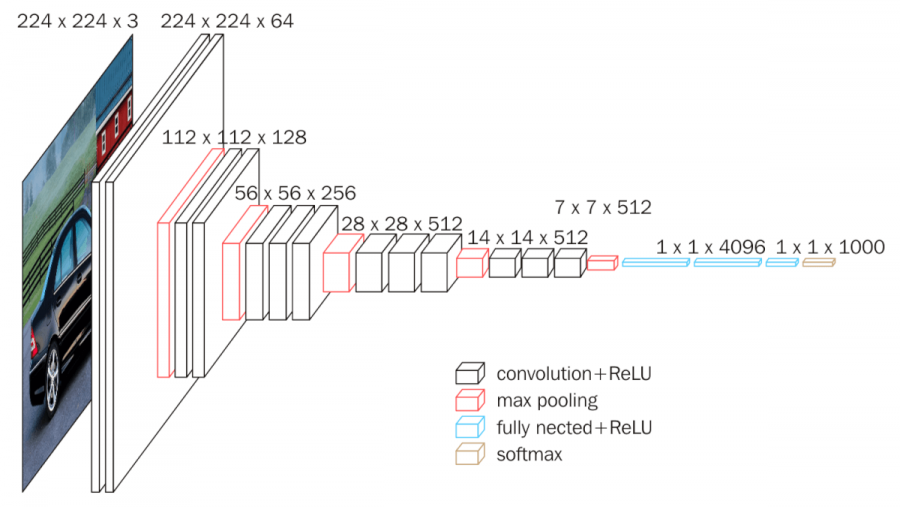

## Loading the VGG16 Network
The original VGG16 model has 1000 output categories. We want to build our own model based on it instead of using the original model. What we really want to take from VGG16 is its well-trained convolutional layers which could extract the features from images. So we use `include_top=True` option to exclude the flatten layer, the fully connnected layers, and the softmax layer. 

We also use a input image resolution(128 * 128) that is different from the original VGG16 input image resolution (224 * 224). The model is designed to take images with resolution 224*224, but it doesn't mean it could only classified images with the specific size.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Clean the Keras session
K.clear_session()

# Define the input shape of the model, which is the size of the images. Here we 
# will be using 224*224 RGB images.
input_shape = (128,128,3)
original_model = VGG16(weights='imagenet',input_shape=input_shape,include_top=False)

original_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Transfer the original model
Next, we will create a new model based on the original VGG16 model.

In [ ]:
# Create a new model
model = Sequential()

# Loop over the layers of the original VGG16 model and add each layer to the new model.
for layer in original_model.layers:
  model.add(layer)

Then we **freeze** every layer in the new model so they don't change when we train the model. We don't want the changes to propogated to the convolutional layers since they are already well-trained. We only want to train the fully connected layers and the softmax layer so the model would fit the new trainning task.

In [ ]:
# freeze the layers
for layer in model.layers:
  layer.trainable = False

Then add a flatten layer, two few fully-connected layers, a dropout layer, and a softmax layer.

In [ ]:
# Flatten layer
model.add(Flatten())

# Fully-connected layer
model.add(Dense(256,activation='relu'))

# Dropout layer
model.add(Dropout(0.5))

# another Fully-connected layer
model.add(Dense(256,activation='relu'))

# Softmax layer
model.add(Dense(3,activation="softmax"))

# show the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

## Dataset
We are using the [Animal Faces-HQ](https://www.kaggle.com/andrewmvd/animal-faces) data from Kaggle. This dataset consists of 16,130 RGB images at 512×512 resolution. There are three domains of classes: 
- Cat
- Dog
- Wildlife

Each class in this dataset contains about **5,000** images, we don't need that much since we took advantage of the well-trained model. We will be using **1,000** images each class for training and **300** images each class for testing.

## Load dataset
The following code is for accessing the dataset from google drive. You can get the dataset from the [Dataset webpage](https://www.kaggle.com/andrewmvd/animal-faces)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are using the `ImageDataGenerator` class provided by the `Keras` package to fetch and resize the images, then load them in to mini-batch.

The original image is 512 * 512. We will resize them to 128 * 128 to reduce the complexity and training time.

In [ ]:
TRAIN_DATA_DIR = './drive/MyDrive/transfer_learning/train'
TEST_DATA_DIR = './drive/MyDrive/transfer_learning/val'
BATCH_SIZE = 500

# generate traing dataset
print("Training Set:")
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    shuffle=True,
                                                    target_size=(128,128), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')
# generate testing dataset
print("\nTesting Set:")
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                  shuffle=True,
                                                  target_size=(128,128), 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical')

Training Set:
Found 3025 images belonging to 3 classes.

Testing Set:
Found 900 images belonging to 3 classes.


Here we print 8 images from the data set with thier labels.

 Cat Dog Wildlife 
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


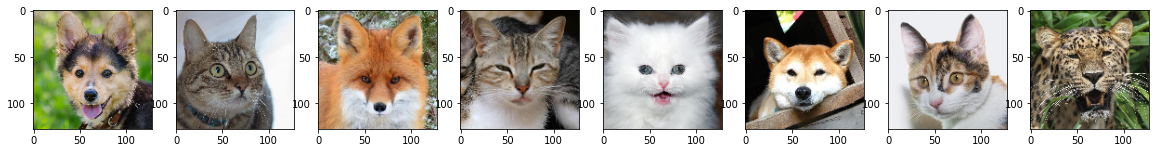

In [ ]:
# Display the image 
def disp_image(im):
  im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255 
  im1 = im1.astype(np.uint8)
  plt.imshow(im1)


plt.figure(figsize=(20,20))
nplot = 8
first_batch = train_generator.next()
for i in range (8): 
  plt.subplot(1,8,i+1) 
  disp_image(first_batch[0][i])

labels = first_batch[1][:8]
print(" Cat Dog Wildlife \n", labels)

## Train the Model
Compile the model and train it using the trainging dataset. Here we are using the `categorical_crossentropy`  loss function

In [ ]:
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])

# Number of epochs
nepochs = 10

# Call the fit_generator function 
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, 
    epochs=nepochs, 
    validation_data=test_generator, 
    validation_steps=test_generator.n // BATCH_SIZE)

Epoch 1/10
6/6 [==============================] - 22s 4s/step - loss: 1.2063 - accuracy: 0.4890 - val_loss: 0.5971 - val_accuracy: 0.7220
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 0.5135 - accuracy: 0.7897 - val_loss: 0.3264 - val_accuracy: 0.8740
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 0.3112 - accuracy: 0.8776 - val_loss: 0.2531 - val_accuracy: 0.8920
Epoch 4/10
6/6 [==============================] - 18s 3s/step - loss: 0.2037 - accuracy: 0.9244 - val_loss: 0.1492 - val_accuracy: 0.9460
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.1860 - accuracy: 0.9248 - val_loss: 0.1424 - val_accuracy: 0.9420
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 0.1425 - accuracy: 0.9501 - val_loss: 0.1301 - val_accuracy: 0.9460
Epoch 7/10
6/6 [==============================] - 21s 3s/step - loss: 0.1152 - accuracy: 0.9576 - val_loss: 0.1589 - val_accuracy: 0.9400
Epoch 8/10
6/6 [==================

## Visulization
Now we plot the history of the training accuracy and test accuracy. 

If both of the two accuracy are low, then the model underfits and we probobailly need to increase the epoch or the size of the training datase.

If the training accuracy looks great while the tst accuracy is low. Then the model overfits the data.

So, we are looking for great result for both the training accuracy and the test accuracy.

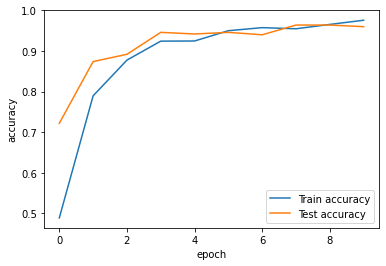

In [ ]:
acc_train = hist.history['accuracy']
acc_test = hist.history['val_accuracy']


# plot the training accuracy
plt.plot(np.arange(0,nepochs),acc_train)

# plot the testing accuracy
plt.plot(np.arange(0,nepochs),acc_test)

plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.legend(['Train accuracy','Test accuracy'])

In [ ]:
print(f"The final train accuracy is %.2f" % acc_train[-1])
print(f"The final test accuracy is %.2f" % acc_test[-1])

The final train accuracy is 0.98
The final test accuracy is 0.96


## Citation

#### VGG16 model

> Hassan, M. U. (2018, November 21). VGG16 - Convolutional Network for Classification and Detection. Retrieved December 10, 2020, from https://neurohive.io/en/popular-networks/vgg16/


#### Dataset
> https://www.kaggle.com/andrewmvd/animal-faces
>
> @inproceedings{choi2020starganv2,
title={StarGAN v2: Diverse Image Synthesis for Multiple Domains},
author={Yunjey Choi and Youngjung Uh and Jaejun Yoo and Jung-Woo Ha},
booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
year={2020}
}

#### Other
> Rangan, S., Wang, Y., &amp; Fletcher, A. K. (2020). Sdrangan/introml. Retrieved December 10, 2020, from https://github.com/sdrangan/introml
